#  ___Convolutional Neural Network for CIPHAR 10 dataset___

## Name: Ritik Saini

## **Index**
1. #### [**Importing libraries**](#id_1)
2. #### [**Reading dataset and creating dataloaders**](#id_2)
3. #### [**Creating stem**](#id_3)
4. #### [**Creating backbone**](#id_4)
5. #### [**Creating classifier**](#id_5)
6. #### [**Full model**](#id_6)
7. #### [**Training and testing model**](#id_7)
8. #### [**Plotting graphs**](#id_8)

## <a id='id_1'> [**Importing libraries**](#id_1)

Following are the libraries that are used to create the desired model.
 - torch : In order to use PyTorch, we call this library. This is used for tensor computation
 several torch's modules are called as well
 - torch.nn : to call neural network's module from within Torch library. This contains predefined codes for building neural network.
 - torch.optim : This calls optimization module from PyTorch library. This includes various optimization algorithms, like Adam which is used for this model.
 - from torchvision import datasets, transforms: This is used to import Torchvision's utilities. Datasets provide pre build datasets in PyTorch. transforms provide image preprocessing functions.
 - from torch.utils.data import DataLoader: This is used to import dataloader module which helps in creating dataloaders for datasets. Batching, shuffling and other predefined utilites can be used.
 - matplotlib.pyplot : This library is used for making graphs which helps in visually representing values. Here, the graphs for loss curve and accuracy curves are plotted using this library.
 - tqdm : This library helps to import progress bars for evaluation of model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

## <a id='id_2'> [**Reading dataset and creating dataloaders**](#id_2)

CIPHAR 10 dataset is used for this model. Firstly transformations are defined for both training and testing datasets.
- Training transformation : The training dataset is randomly changed for model to help generalize features of a class. Then it is converted into a tensor and normalized
- Testing transformation : The testing dataset is not changed to test the model on an unchanged set to check model's working. The testing set is only converted into a tensor and normalized

After transformation, the dataset is read and stored in train set and test set with respective transformations

Then dataloaders are created for both the sets to make batches of 128 images per batch and 2 multi worker processes. Shuffling is True for training dataloader meaning it will load any random 128 pictures into a batch. This is false for testing dataloader

In [4]:
# Defining transformations for both training and testing datasets

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # size is defined as 32x32 pixels and padding is 4 on all sides
    transforms.RandomHorizontalFlip(),     # random flips are done to help model generalise the data
    transforms.ToTensor(),                 # data is converted to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # normalization done with precalculated values of (R,G,B)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),              # data is converted to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) # similar to training transform normalization is done
])

# Reading dataset
train_set = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train) # downloaded is true to enable downloading dataset
                                                                                             # and train is True to download training dataset
test_set = datasets.CIFAR10('./data', train=False, transform=transform_test)                 # train is false to download test dataset

# Creating dataloaders with batch size of 128 pics 
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)



## <a id='id_3'> [**Creating Stem**](#id_3)

The stem takes the image as an input. The stem is basically a convolutional layer with 3 channels(RGB), 128 output channels and 5x5 kernel size.stride and padding are specified to enable better processing of image. stride reduces spatial dimension by half (2) and padding adds pixels(3) around the the image. Bias is False as a batchnormalization is done.
Batchnormalization is done to better generalize the data.
An activation function ReLu is used.
The forward function passes the vector X through each created layer and returns processed X.

In [5]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 128, 5, stride=2, padding=3, bias=False)  # first convolutional layer with arguments explained above
        self.bn = nn.BatchNorm2d(128)                                      # batch normalization function
        self.relu = nn.ReLU(inplace=True)                                  # non linear activation function
        
    # Forward function which 
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

## <a id='id_4'> [**Creating Backbone**](#id_4)

The backbone consists of a block function and a backbone function. The backbone will have N (3 here) number of blocks. Each block will consist of an expert branch and a branch with K convolutional layers.

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, K=4, r=2):   # K(4) and r(2) factors are determined 
        super().__init__()  
        self.K = K   
        
        # Expert branch. Here the features will be first pooled then flatten to make them go through the first fully connected layer.
        # After features are passed through first layer they go through a non linear activation function. Followed by another fully connected
        # layer and then finally a Softmax layer.
        self.expert = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                # pools the feature
            nn.Flatten(),                           # flattens to prepare for fully connected layer
            nn.Linear(in_channels, in_channels//r), # Fully connected layer which reduces channel dimension by r factor
            nn.ReLU(),                              # non linear activation function
            nn.Linear(in_channels//r, K),           # Second fully connected layer which projects channel dimensions to k
            nn.Softmax(dim=1)                       # Softmax layer to get a = [a1 , ... , aK] , dim=1 means normalize weight to sum to 1
        )
        
        # Convolution branches. Here K number of convolutional layers are made where input is parallel processed
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 3, padding=1)  # kernel size is 3X3 and padding=1 to maintain spatial dimensions.
            for _ in range(K)
        ])
        self.relu = nn.ReLU()   # non linear function 

    # forward function which passes the data/value through each layer
    def forward(self, x):
        a = self.expert(x)     # passes through expert branch for expert weights
        outs = [conv(x) for conv in self.convs]  # to compute all convolutional weights
        combined = sum(a[:, i].view(-1,1,1,1) * outs[i] for i in range(self.K))  # combines all weights
        return self.relu(combined)  # non linear activation function 

In [7]:
class Backbone(nn.Module):
    def __init__(self, stem_channels=128, num_blocks=3, K=4):    # stem channels is the feature channel with 128 same as stem
                                                                 # number of blocks is 3 and K factor is 4
        super().__init__()
        self.blocks = nn.ModuleList()
        channels = stem_channels
        
        for i in range(num_blocks):
            next_channels = channels * 2 if i > 0 else channels  # after the first block, the channels will be doubled in each block and forwards
                                                                 # to next block to deepen network
            self.blocks.append(Block(channels, next_channels, K))   # Block function is called with the calculated channels
            channels = next_channels                              # the channels are updated for the next block
            
            
    # forward function which passes values through each layer sequentially
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

## <a id='id_5'> [**Creating Classifier**](#id_5)

Classifier takes input from the output of last block from backbone and returns the final classification.

In [8]:
class Classifier(nn.Module):
    def __init__(self, num_classes=10):   # number of classes in CIPHAR 10 dataset
        super().__init__()
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),      # pools the features 
            nn.Flatten(),                 # flatten to remove spatial dimensions and prepare tensor for the next layer
            nn.Linear(512, num_classes)   # classification layer, 512 is the output from last block
        )
    
    def forward(self , x):
        return self.classifier(x)

## <a id='id_6'> [**Full Model**](#id_6)

This function integrates all the components of the model and is called to run the model

In [9]:
class FullModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = Stem()              # calls stem function
        self.backbone = Backbone()      # calls backbone function
        self.classifier = Classifier()  # calls classifier function

    def forward(self, x):
        x = self.stem(x)     
        x = self.backbone(x) 
        x = self.classifier(x)
        return x

## <a id='id_7'> [**Training and testing model**](#id_7)

The model is trained and tested. Many hyperparameters are used here including optimizers and loss functions. This code block runs the model and provide with accuracy of each epoch. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # makes sure to use GPU if available
model = FullModel().to(device)                                         # transfers whole model to GPU 
print(device)
LossF = nn.CrossEntropyLoss(label_smoothing=0.1)                   # using loss function CrossEntropyLoss to measure the loss 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-4) # optimizer with learning rate and weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.5)              # scheduler to control learning rate  
    
# variables to track result
track = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
# 100 epochs are used during training and testing
for epoch in range(100):
    
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
        inputs, targets = inputs.to(device), targets.to(device)    # the batch is transfered to GPU
            
        optimizer.zero_grad()                 # zero_grad resets any accumulated gradient
        outputs = model(inputs)               # The input propagates through the whole model, also the forward pass during training 
        loss = LossF(outputs, targets)        # calls loss function
        loss.backward()                       # backward pass during training
        optimizer.step()                     
       
        # metric calculation during training
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
   # Validation/testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
        
    with torch.no_grad():   # no_grad to avoid any accumulated gradients
        for inputs, targets in tqdm(test_loader, desc=f'Test Epoch {epoch+1}'):       # progress bar to show during working model
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)                    # forward pass during testing
            loss = LossF(outputs, targets)         # loss calculation
                
            # metric calculation during testing 
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()
        
    # calculating accuracy
    train_acc = 100 * correct / total
    test_acc = 100 * test_correct / test_total
    
    # Updating result variables
    track['train_acc'].append(train_acc)
    track['test_acc'].append(test_acc)
    track['train_loss'].append(train_loss/len(train_loader))
    track['test_loss'].append(test_loss/len(test_loader))
        
    # scheduler updater
    scheduler.step()
        
    # printing result
    print(f'Epoch {epoch+1}:')
    print(f'Train Loss: {track["train_loss"][-1]:.4f} || Validation Loss: {track["test_loss"][-1]:.4f}')
    print(f'Training Accuracy: {train_acc:.2f}% || Validation Accuracy: {test_acc:.2f}%\n')
    
# Final Report
print(f'\n{" Final Results ":-^40}')
print(f'Best Test Accuracy: {max(track["test_acc"]):.2f}%')
print(f'Final Test Accuracy: {track["test_acc"][-1]:.2f}%')
    
        
 

cuda


Test Epoch 1: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Epoch 1:
Train Loss: 1.9707 || Validation Loss: 1.8390
Training Accuracy: 28.13% || Validation Accuracy: 34.82%



Test Epoch 2: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Epoch 2:
Train Loss: 1.7003 || Validation Loss: 1.6290
Training Accuracy: 43.52% || Validation Accuracy: 47.68%



Test Epoch 3: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 3:
Train Loss: 1.5566 || Validation Loss: 1.5413
Training Accuracy: 51.36% || Validation Accuracy: 51.35%



Test Epoch 4: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 4:
Train Loss: 1.4782 || Validation Loss: 1.4680
Training Accuracy: 55.49% || Validation Accuracy: 55.45%



Test Epoch 5: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 5:
Train Loss: 1.4040 || Validation Loss: 1.3744
Training Accuracy: 59.16% || Validation Accuracy: 61.01%



Test Epoch 6: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 6:
Train Loss: 1.3574 || Validation Loss: 1.3715
Training Accuracy: 61.82% || Validation Accuracy: 61.54%



Test Epoch 7: 100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Epoch 7:
Train Loss: 1.3149 || Validation Loss: 1.3732
Training Accuracy: 63.92% || Validation Accuracy: 61.44%



Test Epoch 8: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Epoch 8:
Train Loss: 1.2782 || Validation Loss: 1.3106
Training Accuracy: 65.75% || Validation Accuracy: 64.13%



Test Epoch 9: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 9:
Train Loss: 1.2497 || Validation Loss: 1.2211
Training Accuracy: 67.09% || Validation Accuracy: 68.37%



Test Epoch 10: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Epoch 10:
Train Loss: 1.2193 || Validation Loss: 1.2392
Training Accuracy: 68.45% || Validation Accuracy: 67.44%



Test Epoch 11: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 11:
Train Loss: 1.1641 || Validation Loss: 1.1812
Training Accuracy: 71.17% || Validation Accuracy: 70.49%



Test Epoch 12: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 12:
Train Loss: 1.1480 || Validation Loss: 1.1764
Training Accuracy: 72.09% || Validation Accuracy: 70.68%



Test Epoch 13: 100%|██████████| 79/79 [00:12<00:00,  6.19it/s]


Epoch 13:
Train Loss: 1.1354 || Validation Loss: 1.1719
Training Accuracy: 72.52% || Validation Accuracy: 70.94%



Test Epoch 14: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 14:
Train Loss: 1.1225 || Validation Loss: 1.1478
Training Accuracy: 73.20% || Validation Accuracy: 71.85%



Test Epoch 15: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 15:
Train Loss: 1.1125 || Validation Loss: 1.1355
Training Accuracy: 73.62% || Validation Accuracy: 72.78%



Test Epoch 16: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 16:
Train Loss: 1.1000 || Validation Loss: 1.1199
Training Accuracy: 74.13% || Validation Accuracy: 73.23%



Test Epoch 17: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 17:
Train Loss: 1.0914 || Validation Loss: 1.1293
Training Accuracy: 74.57% || Validation Accuracy: 73.12%



Test Epoch 18: 100%|██████████| 79/79 [00:12<00:00,  6.19it/s]


Epoch 18:
Train Loss: 1.0802 || Validation Loss: 1.0969
Training Accuracy: 75.23% || Validation Accuracy: 74.87%



Test Epoch 19: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 19:
Train Loss: 1.0723 || Validation Loss: 1.1095
Training Accuracy: 75.59% || Validation Accuracy: 74.00%



Test Epoch 20: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 20:
Train Loss: 1.0574 || Validation Loss: 1.0931
Training Accuracy: 76.21% || Validation Accuracy: 75.02%



Test Epoch 21: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 21:
Train Loss: 1.0248 || Validation Loss: 1.0782
Training Accuracy: 77.64% || Validation Accuracy: 75.46%



Test Epoch 22: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 22:
Train Loss: 1.0210 || Validation Loss: 1.0608
Training Accuracy: 78.16% || Validation Accuracy: 76.72%



Test Epoch 23: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


Epoch 23:
Train Loss: 1.0160 || Validation Loss: 1.0607
Training Accuracy: 78.27% || Validation Accuracy: 76.23%



Test Epoch 24: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 24:
Train Loss: 1.0098 || Validation Loss: 1.0959
Training Accuracy: 78.50% || Validation Accuracy: 74.54%



Test Epoch 25: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 25:
Train Loss: 1.0061 || Validation Loss: 1.0365
Training Accuracy: 78.74% || Validation Accuracy: 77.69%



Test Epoch 26: 100%|██████████| 79/79 [00:13<00:00,  5.97it/s]


Epoch 26:
Train Loss: 1.0007 || Validation Loss: 1.0753
Training Accuracy: 78.94% || Validation Accuracy: 75.71%



Test Epoch 27: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Epoch 27:
Train Loss: 0.9956 || Validation Loss: 1.0330
Training Accuracy: 79.35% || Validation Accuracy: 78.05%



Test Epoch 28: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Epoch 28:
Train Loss: 0.9922 || Validation Loss: 1.0269
Training Accuracy: 79.41% || Validation Accuracy: 77.96%



Test Epoch 29: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 29:
Train Loss: 0.9863 || Validation Loss: 1.0337
Training Accuracy: 79.81% || Validation Accuracy: 77.90%



Test Epoch 30: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 30:
Train Loss: 0.9824 || Validation Loss: 1.0262
Training Accuracy: 79.83% || Validation Accuracy: 77.54%



Test Epoch 31: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Epoch 31:
Train Loss: 0.9608 || Validation Loss: 1.0104
Training Accuracy: 80.91% || Validation Accuracy: 78.77%



Test Epoch 32: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 32:
Train Loss: 0.9565 || Validation Loss: 1.0097
Training Accuracy: 81.08% || Validation Accuracy: 79.20%



Test Epoch 33: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Epoch 33:
Train Loss: 0.9572 || Validation Loss: 1.0032
Training Accuracy: 81.14% || Validation Accuracy: 79.34%



Test Epoch 34: 100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


Epoch 34:
Train Loss: 0.9535 || Validation Loss: 1.0057
Training Accuracy: 81.25% || Validation Accuracy: 79.20%



Test Epoch 35: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Epoch 35:
Train Loss: 0.9498 || Validation Loss: 1.0101
Training Accuracy: 81.51% || Validation Accuracy: 78.87%



Test Epoch 36: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Epoch 36:
Train Loss: 0.9471 || Validation Loss: 0.9960
Training Accuracy: 81.64% || Validation Accuracy: 79.44%



Test Epoch 37: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


Epoch 37:
Train Loss: 0.9456 || Validation Loss: 1.0016
Training Accuracy: 81.76% || Validation Accuracy: 78.90%



Test Epoch 38: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Epoch 38:
Train Loss: 0.9435 || Validation Loss: 1.0079
Training Accuracy: 81.87% || Validation Accuracy: 79.37%



Test Epoch 39: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Epoch 39:
Train Loss: 0.9417 || Validation Loss: 1.0003
Training Accuracy: 81.70% || Validation Accuracy: 79.09%



Test Epoch 40: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 40:
Train Loss: 0.9389 || Validation Loss: 0.9972
Training Accuracy: 82.07% || Validation Accuracy: 79.39%



Test Epoch 41: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 41:
Train Loss: 0.9274 || Validation Loss: 0.9860
Training Accuracy: 82.71% || Validation Accuracy: 80.17%



Test Epoch 42: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Epoch 42:
Train Loss: 0.9280 || Validation Loss: 0.9802
Training Accuracy: 82.56% || Validation Accuracy: 80.42%



Test Epoch 43: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 43:
Train Loss: 0.9247 || Validation Loss: 0.9835
Training Accuracy: 82.73% || Validation Accuracy: 79.98%



Test Epoch 44: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 44:
Train Loss: 0.9235 || Validation Loss: 0.9832
Training Accuracy: 82.66% || Validation Accuracy: 80.06%



Test Epoch 45: 100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Epoch 45:
Train Loss: 0.9208 || Validation Loss: 0.9811
Training Accuracy: 82.82% || Validation Accuracy: 80.52%



Test Epoch 46: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 46:
Train Loss: 0.9187 || Validation Loss: 0.9789
Training Accuracy: 83.03% || Validation Accuracy: 80.46%



Test Epoch 47: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 47:
Train Loss: 0.9209 || Validation Loss: 0.9803
Training Accuracy: 82.82% || Validation Accuracy: 80.14%



Test Epoch 48: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 48:
Train Loss: 0.9183 || Validation Loss: 0.9848
Training Accuracy: 82.84% || Validation Accuracy: 79.98%



Test Epoch 49: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 49:
Train Loss: 0.9177 || Validation Loss: 0.9750
Training Accuracy: 83.26% || Validation Accuracy: 80.88%



Test Epoch 50: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 50:
Train Loss: 0.9171 || Validation Loss: 0.9797
Training Accuracy: 83.03% || Validation Accuracy: 80.37%



Test Epoch 51: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 51:
Train Loss: 0.9110 || Validation Loss: 0.9729
Training Accuracy: 83.27% || Validation Accuracy: 80.48%



Test Epoch 52: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 52:
Train Loss: 0.9092 || Validation Loss: 0.9768
Training Accuracy: 83.56% || Validation Accuracy: 80.75%



Test Epoch 53: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 53:
Train Loss: 0.9078 || Validation Loss: 0.9716
Training Accuracy: 83.59% || Validation Accuracy: 80.97%



Test Epoch 54: 100%|██████████| 79/79 [00:13<00:00,  5.70it/s]


Epoch 54:
Train Loss: 0.9071 || Validation Loss: 0.9726
Training Accuracy: 83.53% || Validation Accuracy: 80.82%



Test Epoch 55: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Epoch 55:
Train Loss: 0.9060 || Validation Loss: 0.9727
Training Accuracy: 83.81% || Validation Accuracy: 80.77%



Test Epoch 56: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 56:
Train Loss: 0.9064 || Validation Loss: 0.9682
Training Accuracy: 83.62% || Validation Accuracy: 81.07%



Test Epoch 57: 100%|██████████| 79/79 [00:12<00:00,  6.30it/s]


Epoch 57:
Train Loss: 0.9071 || Validation Loss: 0.9710
Training Accuracy: 83.54% || Validation Accuracy: 81.08%



Test Epoch 58: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 58:
Train Loss: 0.9054 || Validation Loss: 0.9690
Training Accuracy: 83.63% || Validation Accuracy: 80.85%



Test Epoch 59: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 59:
Train Loss: 0.9057 || Validation Loss: 0.9681
Training Accuracy: 83.68% || Validation Accuracy: 80.99%



Test Epoch 60: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 60:
Train Loss: 0.9043 || Validation Loss: 0.9696
Training Accuracy: 83.78% || Validation Accuracy: 80.84%



Test Epoch 61: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 61:
Train Loss: 0.8998 || Validation Loss: 0.9687
Training Accuracy: 83.90% || Validation Accuracy: 81.13%



Test Epoch 62: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 62:
Train Loss: 0.8998 || Validation Loss: 0.9658
Training Accuracy: 84.06% || Validation Accuracy: 81.19%



Test Epoch 63: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 63:
Train Loss: 0.9018 || Validation Loss: 0.9668
Training Accuracy: 83.93% || Validation Accuracy: 81.12%



Test Epoch 64: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 64:
Train Loss: 0.8985 || Validation Loss: 0.9677
Training Accuracy: 84.02% || Validation Accuracy: 80.73%



Test Epoch 65: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 65:
Train Loss: 0.8995 || Validation Loss: 0.9669
Training Accuracy: 84.03% || Validation Accuracy: 81.38%



Test Epoch 66: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 66:
Train Loss: 0.8999 || Validation Loss: 0.9661
Training Accuracy: 83.90% || Validation Accuracy: 81.22%



Test Epoch 67: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 67:
Train Loss: 0.8989 || Validation Loss: 0.9649
Training Accuracy: 84.07% || Validation Accuracy: 81.36%



Test Epoch 68: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


Epoch 68:
Train Loss: 0.8973 || Validation Loss: 0.9656
Training Accuracy: 84.08% || Validation Accuracy: 81.18%



Test Epoch 69: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 69:
Train Loss: 0.8972 || Validation Loss: 0.9650
Training Accuracy: 84.05% || Validation Accuracy: 81.21%



Test Epoch 70: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 70:
Train Loss: 0.8977 || Validation Loss: 0.9675
Training Accuracy: 84.01% || Validation Accuracy: 81.16%



Test Epoch 71: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Epoch 71:
Train Loss: 0.8957 || Validation Loss: 0.9643
Training Accuracy: 84.27% || Validation Accuracy: 81.18%



Test Epoch 72: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 72:
Train Loss: 0.8944 || Validation Loss: 0.9656
Training Accuracy: 84.25% || Validation Accuracy: 81.21%



Test Epoch 73: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Epoch 73:
Train Loss: 0.8964 || Validation Loss: 0.9647
Training Accuracy: 84.00% || Validation Accuracy: 81.23%



Test Epoch 74: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


Epoch 74:
Train Loss: 0.8956 || Validation Loss: 0.9663
Training Accuracy: 84.09% || Validation Accuracy: 81.29%



Test Epoch 75: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


Epoch 75:
Train Loss: 0.8955 || Validation Loss: 0.9648
Training Accuracy: 84.23% || Validation Accuracy: 81.14%



Test Epoch 76: 100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


Epoch 76:
Train Loss: 0.8944 || Validation Loss: 0.9644
Training Accuracy: 84.22% || Validation Accuracy: 81.24%



Test Epoch 77: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Epoch 77:
Train Loss: 0.8950 || Validation Loss: 0.9631
Training Accuracy: 84.24% || Validation Accuracy: 81.35%



Test Epoch 78: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Epoch 78:
Train Loss: 0.8944 || Validation Loss: 0.9635
Training Accuracy: 84.46% || Validation Accuracy: 81.29%



Test Epoch 79: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Epoch 79:
Train Loss: 0.8950 || Validation Loss: 0.9642
Training Accuracy: 84.16% || Validation Accuracy: 81.17%



Test Epoch 80: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 80:
Train Loss: 0.8942 || Validation Loss: 0.9656
Training Accuracy: 84.19% || Validation Accuracy: 81.07%



Test Epoch 81: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 81:
Train Loss: 0.8952 || Validation Loss: 0.9626
Training Accuracy: 84.02% || Validation Accuracy: 81.29%



Test Epoch 82: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 82:
Train Loss: 0.8920 || Validation Loss: 0.9633
Training Accuracy: 84.41% || Validation Accuracy: 81.36%



Test Epoch 83: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 83:
Train Loss: 0.8936 || Validation Loss: 0.9623
Training Accuracy: 84.27% || Validation Accuracy: 81.44%



Test Epoch 84: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 84:
Train Loss: 0.8916 || Validation Loss: 0.9628
Training Accuracy: 84.26% || Validation Accuracy: 81.24%



Test Epoch 85: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 85:
Train Loss: 0.8930 || Validation Loss: 0.9631
Training Accuracy: 84.38% || Validation Accuracy: 81.32%



Test Epoch 86: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 86:
Train Loss: 0.8930 || Validation Loss: 0.9623
Training Accuracy: 84.34% || Validation Accuracy: 81.40%



Test Epoch 87: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 87:
Train Loss: 0.8920 || Validation Loss: 0.9624
Training Accuracy: 84.23% || Validation Accuracy: 81.22%



Test Epoch 88: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 88:
Train Loss: 0.8920 || Validation Loss: 0.9625
Training Accuracy: 84.42% || Validation Accuracy: 81.46%



Test Epoch 89: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 89:
Train Loss: 0.8913 || Validation Loss: 0.9619
Training Accuracy: 84.28% || Validation Accuracy: 81.30%



Test Epoch 90: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 90:
Train Loss: 0.8919 || Validation Loss: 0.9621
Training Accuracy: 84.44% || Validation Accuracy: 81.24%



Test Epoch 91: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Epoch 91:
Train Loss: 0.8923 || Validation Loss: 0.9621
Training Accuracy: 84.40% || Validation Accuracy: 81.32%



Test Epoch 92: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 92:
Train Loss: 0.8911 || Validation Loss: 0.9627
Training Accuracy: 84.37% || Validation Accuracy: 81.34%



Test Epoch 93: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Epoch 93:
Train Loss: 0.8924 || Validation Loss: 0.9620
Training Accuracy: 84.37% || Validation Accuracy: 81.42%



Test Epoch 94: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


Epoch 94:
Train Loss: 0.8918 || Validation Loss: 0.9633
Training Accuracy: 84.25% || Validation Accuracy: 81.28%



Test Epoch 95: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Epoch 95:
Train Loss: 0.8922 || Validation Loss: 0.9621
Training Accuracy: 84.30% || Validation Accuracy: 81.44%



Test Epoch 96: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Epoch 96:
Train Loss: 0.8932 || Validation Loss: 0.9631
Training Accuracy: 84.26% || Validation Accuracy: 81.30%



Test Epoch 97: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Epoch 97:
Train Loss: 0.8929 || Validation Loss: 0.9622
Training Accuracy: 84.20% || Validation Accuracy: 81.47%



Test Epoch 98: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Epoch 98:
Train Loss: 0.8909 || Validation Loss: 0.9626
Training Accuracy: 84.48% || Validation Accuracy: 81.19%



Test Epoch 99: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Epoch 99:
Train Loss: 0.8898 || Validation Loss: 0.9628
Training Accuracy: 84.37% || Validation Accuracy: 81.10%



Test Epoch 100: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]

Epoch 100:
Train Loss: 0.8920 || Validation Loss: 0.9624
Training Accuracy: 84.47% || Validation Accuracy: 81.26%


------------ Final Results -------------
Best Test Accuracy: 81.47%
Final Test Accuracy: 81.26%


## <a id='id_8'> [**Plotting curves on graph**](#id_8)

Graphs are plotted to represent the loss function and accuracies of training and testing/validation sets.

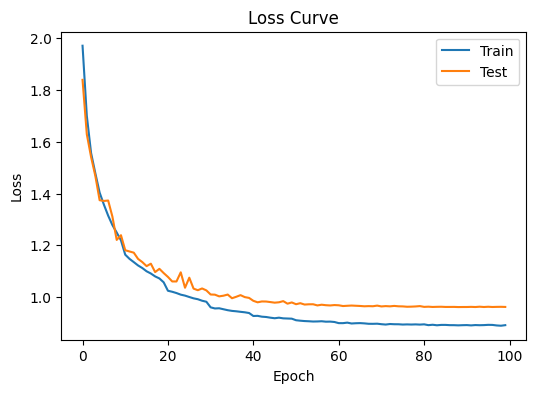

In [ ]:

# graph for plotting evolution curve of loss 
plt.figure(figsize=(6,4))
plt.plot(track['train_loss'], label='Train')
plt.plot(track['test_loss'], label='Test')
plt.title('Loss Curve'), plt.xlabel('Epoch'),plt.ylabel("Loss"), plt.legend(loc='upper right')

plt.show()


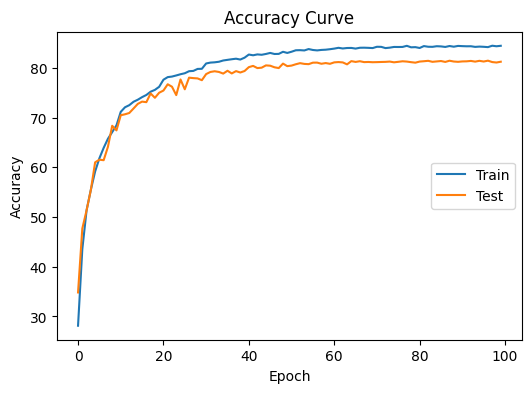

In [26]:
# graph for plotting accuracy curve for both training and testing/validation sets  
plt.figure(figsize=(6,4))  
plt.plot(track['train_acc'], label='Train')
plt.plot(track['test_acc'], label='Test')
plt.title('Accuracy Curve'), plt.xlabel('Epoch'),plt.ylabel("Accuracy"), plt.legend(loc='right')
        
plt.show()